In [1]:
import pandas as pd
import glob
import sys
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

# Load variables and translations

The FBI provides the raw SHR data files in a fixed-width format, with non-descriptive variable names. Additionally, many fields use numeric codes or abbreviations, which require translating to their full descriptions. We have extracted the variable names, positions, and translations from the SHR codebook, and in this step prepare that metadata to be used in loading the main data.

In [2]:
variables = pd.read_csv("../../data/documentation/shr-variables.csv")
variables.head()

,variable_num,variable_name,location_str,location_start,location_end
0,V1,IDENTIFIER CODE,1-1,1,1
1,V2,NUMERIC STATE CODE,2-3,2,3
2,V3,ORI CODE,4-10,4,10
3,V4,GROUP,11-12,11,12
4,V5,GEOGRAPHIC DIVISION,13-13,13,13


In [3]:
variables["width"] = 1 + variables["location_end"] - variables["location_start"]
variables.head(10)

,variable_num,variable_name,location_str,location_start,location_end,width
0,V1,IDENTIFIER CODE,1-1,1,1,1
1,V2,NUMERIC STATE CODE,2-3,2,3,2
2,V3,ORI CODE,4-10,4,10,7
3,V4,GROUP,11-12,11,12,2
4,V5,GEOGRAPHIC DIVISION,13-13,13,13,1
5,V6,YEAR,14-17,14,17,4
6,V7,POPULATION,18-26,18,26,9
7,V8,COUNTY,27-29,27,29,3
8,V9,MSA CODE,30-32,30,32,3
9,V10,MSA INDICATION,33-33,33,33,1


In [4]:
# Codebook incorrectly states that year variable has width of 4
variables.loc[variables["variable_name"] == "YEAR", "width"] = 2

In [5]:
translations = (
    pd.read_csv(
        "../../data/documentation/shr-translations.csv"
    )
    .merge(
        variables[[ "variable_num", "variable_name", "width" ]],
        how = "left",
        on = [ "variable_num" ],
    ).assign(
        value_padded = lambda df: df.apply(lambda x: x["value"].zfill(x["width"]), axis = 1)
    )
)
translations.head()

,variable_num,value,translation,variable_name,width,value_padded
0,V1,6,SHR master file,IDENTIFIER CODE,1,6
1,V2,1,Alabama,NUMERIC STATE CODE,2,01
2,V2,2,Arizona,NUMERIC STATE CODE,2,02
3,V2,3,Arkansas,NUMERIC STATE CODE,2,03
4,V2,4,California,NUMERIC STATE CODE,2,04


In [6]:
translation_dict = (
    translations.groupby("variable_name")
    .apply(lambda grp: grp.set_index("value_padded")["translation"].to_dict())
    .to_dict()
)

In [7]:
def translate(var_name):
    d = translation_dict[var_name]
    def fn(label):
        if label == "":
            return ""
        else:
            return d[label]
    return fn

# Load data

In this step, we load and parse the raw data for each year since 1980.

In [8]:
import struct
fieldwidths = variables["width"].tolist()
fmtstring = ' '.join('{}s'.format(fw) for fw in fieldwidths)
fieldstruct = struct.Struct(fmtstring)
parse_bytes = fieldstruct.unpack_from

In [9]:
def parse_line(line):
    line = line.strip()
    line = line + b" " * (268 - len(line))
    return [ x.strip().decode() for x in parse_bytes(line) ]

In [10]:
def parse_annual_file(path):
    sys.stderr.write(path + "\n")
    return pd.DataFrame(
        list(map(parse_line, open(path, "rb"))),
        columns = variables["variable_name"].values
    ).pipe(lambda x: x[
        x["ORI CODE"] != ""
    ])

In [11]:
paths = [ x for x in sorted(glob.glob("../../data/raw/shr/SHR*.DAT"))
    if int(x[-8:-4]) >= 1980 ]
paths[:3]

['../../data/raw/shr/SHR1980.DAT',
 '../../data/raw/shr/SHR1981.DAT',
 '../../data/raw/shr/SHR1982.DAT']

In [12]:
shr = pd.concat(list(map(parse_annual_file, paths)))
shr.head()

../../data/raw/shr/SHR1980.DAT
../../data/raw/shr/SHR1981.DAT
../../data/raw/shr/SHR1982.DAT
../../data/raw/shr/SHR1983.DAT
../../data/raw/shr/SHR1984.DAT
../../data/raw/shr/SHR1985.DAT
../../data/raw/shr/SHR1986.DAT
../../data/raw/shr/SHR1987.DAT
../../data/raw/shr/SHR1988.DAT
../../data/raw/shr/SHR1989.DAT
../../data/raw/shr/SHR1990.DAT
../../data/raw/shr/SHR1991.DAT
../../data/raw/shr/SHR1992.DAT
../../data/raw/shr/SHR1993.DAT
../../data/raw/shr/SHR1994.DAT
../../data/raw/shr/SHR1995.DAT
../../data/raw/shr/SHR1996.DAT
../../data/raw/shr/SHR1997.DAT
../../data/raw/shr/SHR1998.DAT
../../data/raw/shr/SHR1999.DAT
../../data/raw/shr/SHR2000.DAT
../../data/raw/shr/SHR2001.DAT
../../data/raw/shr/SHR2002.DAT
../../data/raw/shr/SHR2003.DAT
../../data/raw/shr/SHR2004.DAT
../../data/raw/shr/SHR2005.DAT
../../data/raw/shr/SHR2006.DAT
../../data/raw/shr/SHR2007.DAT
../../data/raw/shr/SHR2008.DAT
../../data/raw/shr/SHR2009.DAT
../../data/raw/shr/SHR2010.DAT
../../data/raw/shr/SHR2011.DAT
../../da

,IDENTIFIER CODE,NUMERIC STATE CODE,ORI CODE,GROUP,GEOGRAPHIC DIVISION,YEAR,POPULATION,COUNTY,MSA CODE,MSA INDICATION,...,OFFENDER 10: CIRCUMSTANCE,OFFENDER 10: SUB-CIRCUMSTANCE,OFFENDER 11: AGE,OFFENDER 11: SEX,OFFENDER 11: RACE,OFFENDER 11: ETHNIC ORIGIN,OFFENDER 11: WEAPON,OFFENDER 11: RELATIONSHIP TO FIRST VICTIM,OFFENDER 11: CIRCUMSTANCE,OFFENDER 11: SUB-CIRCUMSTANCE
0,6,01,AL00100,9A,6,80,000172148,037,098,1,...,,,,,,,,,,
1,6,01,AL00100,9A,6,80,000172148,037,098,1,...,,,,,,,,,,
2,6,01,AL00100,9A,6,80,000172148,037,098,1,...,,,,,,,,,,
3,6,01,AL00100,9A,6,80,000172148,037,098,1,...,,,,,,,,,,
4,6,01,AL00100,9A,6,80,000172148,037,098,1,...,,,,,,,,,,


In [13]:
shr.head().T.head(30)

,0,1,2,3,4
IDENTIFIER CODE,6,6,6,6,6
NUMERIC STATE CODE,01,01,01,01,01
ORI CODE,AL00100,AL00100,AL00100,AL00100,AL00100
GROUP,9A,9A,9A,9A,9A
GEOGRAPHIC DIVISION,6,6,6,6,6
YEAR,80,80,80,80,80
POPULATION,000172148,000172148,000172148,000172148,000172148
COUNTY,037,037,037,037,037
MSA CODE,098,098,098,098,098
MSA INDICATION,1,1,1,1,1


In [14]:
shr["year"] = shr["YEAR"].apply(lambda x: int(x) + (1900 if x > "50" else 2000))

In [15]:
def shr_date_convert(shr_date):
    m, d, y = map(int, (shr_date[:2], shr_date[2:4], shr_date[4:]))
    if y < 1000:
        y = (2000 + y) if y < 60 else (1900 + y)
    return "{:04d}-{:02d}-{:02d}".format(y, m, d)

In [16]:
shr["last_update"] = shr["LAST UPDATE"].apply(shr_date_convert)

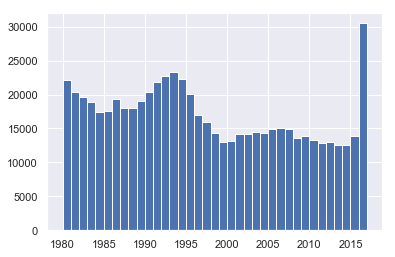

In [17]:
(
    shr
    ["year"]
    .hist(bins = range(1980, 2018))
);

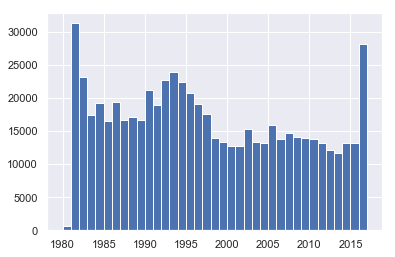

In [18]:
(
    shr
    ["last_update"].str.slice(0, 4)
    .astype(int)
    .hist(bins = range(1980, 2018))
);

# Add dataset-unique incident IDs

There is no single variable in the SHR data that uniquely identifies an incident. So here we create one by combining the agency's seven-digit ORI code, the year and month of the incident, and the sequence number of the incident within that year/month.

In [19]:
shr["incident_uid"] = (
    shr
    [[
        "ORI CODE",
        "YEAR",
        "MONTH OF OFFENSE",
        "INCIDENT NUMBER",
    ]]
    .astype(str)\
    .apply("|".join, axis = 1)
)
    
shr["incident_uid"].head()

0    AL00100|80|02|001
1    AL00100|80|03|001
2    AL00100|80|04|001
3    AL00100|80|05|001
4    AL00100|80|06|001
Name: incident_uid, dtype: object

# Deduplicate reports

Using the scheme above, a very small number of incidents IDs appear in the data more than once. In this step, we remove the duplicates, selecting only the most recently updated row for each `incident_uid`.

In [20]:
shr["incident_uid"].value_counts().value_counts()

1    632884
2        29
3         7
Name: incident_uid, dtype: int64

In [21]:
shr_dedup = (
    shr
    .sort_values("last_update", ascending = False)
    .drop_duplicates(subset = [ "incident_uid" ])
)

In [22]:
len(shr_dedup)

632920

# Convert to "tidy" layout

The raw data is very "wide" — because it tries to fit every detail about an incident into a single row, it can be difficult to analyze efficiently. In this step, we "tidy" up the data into three separate tables: one for each incident, one for each victim, and one for each offender.

## Incidents

In [23]:
incidents_tidy = (
    shr_dedup
    [[
        "ORI CODE",
        "incident_uid",
        "year",
        "MONTH OF OFFENSE",
        "INCIDENT NUMBER",
        "TYPE OF OFFENSE: HOMICIDE",
        "SITUATION"
    ]]
    .copy()
)

incidents_tidy.head()

,ORI CODE,incident_uid,year,MONTH OF OFFENSE,INCIDENT NUMBER,TYPE OF OFFENSE: HOMICIDE,SITUATION
12022,SC04200,SC04200|17|10|001,2017,10,001,A,A
11701,SC00201,SC00201|17|05|001,2017,05,001,A,C
11683,RI00409,RI00409|17|06|002,2017,06,002,A,B
11684,RI00409,RI00409|17|07|001,2017,07,001,A,A
11685,RI00409,RI00409|17|07|002,2017,07,002,A,B


In [24]:
incidents_tidy["TYPE OF OFFENSE: HOMICIDE"].value_counts()

A    624461
B      8459
Name: TYPE OF OFFENSE: HOMICIDE, dtype: int64

In [25]:
murder_incident_uids = (
    incidents_tidy
    .loc[lambda df: df["TYPE OF OFFENSE: HOMICIDE"] == "A"]
    ["incident_uid"]
)

len(murder_incident_uids)

624461

In [26]:
incidents_tidy["SITUATION"].value_counts()

A    355946
B    183011
C     69233
D     13440
F      7056
E      4234
Name: SITUATION, dtype: int64

## Victims

In [27]:
def categorify_tidy_columns(df):
    for c in df.columns:
        if c in [ "incident_uid", "ORI CODE", "year", "num", "AGE" ]:
            continue
        df[c] = df[c].astype("category")
    return df

In [28]:
victims_tidy = (
    shr_dedup
    .melt(
        id_vars = [ "incident_uid", "ORI CODE", "year" ],
        value_vars = [ c for c in shr_dedup.columns if c[:7] == "VICTIM " ]
    )
    .loc[lambda x: x["value"] != ""]
    .assign(
        num = lambda x: x["variable"].str.extract("^VICTIM (\d+):", expand = False).astype(int),
        metric = lambda x: x["variable"].str.extract("^VICTIM \d+: (.*)", expand = False),
    )
    .assign(
        victim_uid = lambda x: x["incident_uid"] + "-" + x["num"].astype(str)
    )
    .set_index([
        "incident_uid",
        "victim_uid",
        "ORI CODE",
        "year",
        "num",
        "metric"
    ])
    ["value"]
    .unstack()
    .reset_index()
    .pipe(categorify_tidy_columns)
)
    
victims_tidy.head()

metric,incident_uid,victim_uid,ORI CODE,year,num,AGE,ETHNIC ORIGIN,RACE,SEX
0,AK00101|00|01|001,AK00101|00|01|001-1,AK00101,2000,1,25,NaN,B,F
1,AK00101|00|01|002,AK00101|00|01|002-1,AK00101,2000,1,31,NaN,W,F
2,AK00101|00|01|003,AK00101|00|01|003-1,AK00101,2000,1,01,NaN,A,M
3,AK00101|00|02|001,AK00101|00|02|001-1,AK00101,2000,1,BB,NaN,A,M
4,AK00101|00|03|001,AK00101|00|03|001-1,AK00101,2000,1,29,NaN,I,F


## Offenders

In [29]:
offenders_tidy = (
    shr_dedup
    .melt(
        id_vars = [ "incident_uid" ],
        value_vars = [ c for c in shr_dedup.columns if c[:9] == "OFFENDER "  ]
    )
    .loc[lambda x: x["value"] != ""]
    .assign(
        num = lambda x: x["variable"].str.extract("^OFFENDER (\d+):", expand = False).astype(int),
        metric = lambda x: x["variable"].str.extract("^OFFENDER \d+: (.*)", expand = False),
    ).set_index([
        "incident_uid",
        "num",
        "metric"
    ])
    ["value"]
    .unstack()
    .reset_index()
    .pipe(categorify_tidy_columns)  
)

offenders_tidy.head()

metric,incident_uid,num,AGE,CIRCUMSTANCE,ETHNIC ORIGIN,RACE,RELATIONSHIP TO FIRST VICTIM,SEX,SUB-CIRCUMSTANCE,WEAPON
0,AK00101|00|01|001,1,28,60,NaN,B,WI,M,NaN,12
1,AK00101|00|01|002,1,18,03,NaN,I,OK,M,NaN,12
2,AK00101|00|01|002,2,18,03,NaN,I,OK,M,NaN,12
3,AK00101|00|01|003,1,12,59,NaN,A,OF,M,NaN,40
4,AK00101|00|02|001,1,39,59,NaN,A,AQ,F,NaN,40


# Assign additional variables

For the ease of subsequent analysis, in this step we create a few additional variables, based on the variables already in the data.

## Which offender demographics are reported?

In [30]:
(
    offenders_tidy
    [[
        "AGE",
        "SEX",
        "RACE",
        "ETHNIC ORIGIN"
    ]]
    .isnull()
    .mean()
)

metric
AGE              0.000000
SEX              0.000000
RACE             0.000000
ETHNIC ORIGIN    0.464262
dtype: float64

In [31]:
offenders_tidy["sex_reported"] = (offenders_tidy["SEX"] != "U")
offenders_tidy["sex_reported"].mean()

0.7369041799234379

In [32]:
offenders_tidy["race_reported"] = (offenders_tidy["RACE"] != "U")
offenders_tidy["race_reported"].mean()

0.7265685732374839

In [33]:
offenders_tidy["age_reported"] = (offenders_tidy["AGE"] != "00")
offenders_tidy["age_reported"].mean()

0.688096554708725

In [34]:
incidents_tidy["offender_age_reported"] = (
    incidents_tidy["incident_uid"]
    .isin(
        offenders_tidy
        .loc[lambda df: df["age_reported"] == True]
        ["incident_uid"]
    )
    .astype(int)
)

incidents_tidy["offender_age_reported"].mean()

0.6607564937116855

In [35]:
(
    offenders_tidy
    .groupby([
        "age_reported",
        "sex_reported"        
    ])
    .size()
    .unstack()
    .pipe(lambda x: x / x.sum().sum())
)

sex_reported,False,True
age_reported,,
False,0.262250,0.049653
True,0.000845,0.687251


## Domestic/family violence indicator

In [36]:
REL_DV = [
    "HU", # Husband
    "WI", # Wife
    "CH", # Common-law husband
    "CW", # Common-law wife
    "XH", # Ex-husband
    "XW", # Ex-wife
    "BF", # Boyfriend
    "GF", # Girlfriend
    "HO", # Homosexual relationship
]

REL_FV = [
    "BR", # Brother
    "CH", # Common-law husband
    "CW", # Common-law wife
    "DA", # Daughter
    "FA", # Father
    "HU", # Husband
    "IL", # In-law
    "MO", # Mother
    "OF", # Other family
    "SD", # Stepdaughter
    "SF", # Stepfather
    "SI", # Sister
    "SM", # Stepmother
    "SO", # Son
    "SS", # Stepson
    "WI", # Wife
]

In [37]:
(
    offenders_tidy
    .groupby(["RELATIONSHIP TO FIRST VICTIM"])
    .size()
    .pipe(lambda x: x / x.sum())
    .to_frame("Proportion")
    .reset_index()
    .assign(
        Relationship = lambda df: df["RELATIONSHIP TO FIRST VICTIM"].apply(
            translate("OFFENDER 1: RELATIONSHIP TO FIRST VICTIM")
        ),
        domestic_violence_ind = lambda df: df["RELATIONSHIP TO FIRST VICTIM"].isin(REL_DV),
        family_violence_ind = lambda df: df["RELATIONSHIP TO FIRST VICTIM"].isin(REL_FV),
    )
    .drop(columns = ["RELATIONSHIP TO FIRST VICTIM"])
    .set_index("Relationship")
    .sort_values("Proportion", ascending = False)
    .round(3)
)

,Proportion,domestic_violence_ind,family_violence_ind
Relationship,,,
Relationship not determined,0.356,False,False
Acquaintance,0.208,False,False
Stranger,0.182,False,False
Other - known to victim,0.054,False,False
Friend,0.035,False,False
Wife,0.030,True,True
Girlfriend,0.023,True,False
Other family,0.014,False,True
Son,0.013,False,True


In [38]:
incidents_tidy["domestic_violence_ind"] = (
    incidents_tidy["incident_uid"]
    .isin(
        offenders_tidy
        .loc[lambda df: df["RELATIONSHIP TO FIRST VICTIM"].isin(REL_DV)]
        ["incident_uid"]
    )
    .astype(int)
)

incidents_tidy["domestic_violence_ind"].mean()

0.10377614864437844

In [39]:
incidents_tidy["family_violence_ind"] = (
    incidents_tidy["incident_uid"]
    .isin(
        offenders_tidy
        .loc[lambda df: df["RELATIONSHIP TO FIRST VICTIM"].isin(REL_FV)]
        ["incident_uid"]
    )
    .astype(int)
)

incidents_tidy["family_violence_ind"].mean()

0.1320403842507742

In [40]:
(
    incidents_tidy["domestic_violence_ind"] |
    incidents_tidy["family_violence_ind"]
).mean()

0.17870662958983757

## Firearm indicator

In [41]:
offenders_tidy["weapon_tr"] = (
    offenders_tidy["WEAPON"]
    .apply(translate("OFFENDER 1: WEAPON"))
)

offenders_tidy["weapon_tr"].value_counts()

Handgun - pistol, revolver, etc         378146
Knife or cutting instrument             107039
Firearm, type not stated                 57957
Personal weapons, includes beating       44686
Other or type unknown                    37914
Blunt object - hammer, club, etc         35742
Shotgun                                  34521
Rifle                                    26073
Strangulation - hanging                   8997
Fire                                      5040
Asphyxiation - includes death by gas      4541
Other gun                                 3333
Narcotics or drugs, sleeping pills        2213
Drowning                                  1328
Poison - does not include gas              481
Explosives                                 439
Pushed or thrown out window                224
Name: weapon_tr, dtype: int64

In [42]:
offenders_tidy["firearm_ind"] = (
    offenders_tidy
    ["weapon_tr"].str.contains(
        r"gun|rifle|firearm",
        na = False,
        case = False
    )
    .astype(int)
)

offenders_tidy["firearm_ind"].mean()

0.6678874917520844

In [43]:
incidents_tidy["firearm_ind"] = (
    incidents_tidy["incident_uid"].isin(
        offenders_tidy
        .loc[lambda df: df["firearm_ind"] == 1]
        ["incident_uid"]
    )
    .astype(int)
)

incidents_tidy["firearm_ind"].mean()

0.661186247867029

## Examine circumstance-related variables

In [44]:
offenders_tidy["CIRCUMSTANCE"].isnull().mean()

0.0

In [45]:
offenders_tidy["circumstance_tr"] = (
    offenders_tidy["CIRCUMSTANCE"]
    .apply(translate("OFFENDER 1: CIRCUMSTANCE"))
)

In [46]:
(
    offenders_tidy
    .merge(
        incidents_tidy,
        how = "left",
        on = "incident_uid"
    )
    .groupby([
        "circumstance_tr",
        "TYPE OF OFFENSE: HOMICIDE"
    ])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
    .sort_values([ "A", "B" ], ascending = False)
)

TYPE OF OFFENSE: HOMICIDE,A,B
circumstance_tr,,
Circumstances undetermined,198833,0
Other arguments,190698,0
Other,89700,0
Robbery,72519,0
Narcotic drug laws,32299,0
Juvenile gang killings,30175,0
Felon killed by police,18790,0
Other - not specified,16508,0
Argument over money or property,13877,0


In [47]:
main_circumstances = (
    offenders_tidy
    .sort_values([ "incident_uid", "num" ])
    .drop_duplicates(subset = [ "incident_uid" ])
    [[ "incident_uid", "circumstance_tr" ]]
    .rename(columns = {
        "circumstance_tr": "circumstance_main"
    })
)

main_circumstances.head()

metric,incident_uid,circumstance_main
0,AK00101|00|01|001,Other
1,AK00101|00|01|002,Robbery
3,AK00101|00|01|003,All other manslaughter by negligence
4,AK00101|00|02|001,All other manslaughter by negligence
5,AK00101|00|03|001,Other


In [48]:
excluded_incident_uids = (
    offenders_tidy
    .loc[lambda df: df["circumstance_tr"].isin([
        "Institutional killings",
        "Abortion"
    ])]
    ["incident_uid"].unique()
)

len(excluded_incident_uids)

841

In [49]:
justifiable_incident_uids = (
    offenders_tidy
    .loc[lambda df: df["circumstance_tr"].isin([
        "Felon killed by police",
        "Felon killed by private citizen",
    ])]
    ["incident_uid"].unique()
)

len(justifiable_incident_uids)

24664

# Standardize victims

... and exclude institutional killings and abortion.

In [50]:
victims_standardized = (
    incidents_tidy
    
    # Remove institutional killings and abortion 
    .loc[lambda df: ~df["incident_uid"].isin(excluded_incident_uids)]
    
    [[
        "incident_uid",
        "year",
        "MONTH OF OFFENSE",
        "ORI CODE",
        "TYPE OF OFFENSE: HOMICIDE",
        "offender_age_reported",
        "firearm_ind",
        "domestic_violence_ind",
        "family_violence_ind",
    ]]
    
    .assign(
        
        month = lambda x: x["MONTH OF OFFENSE"].astype(int),
        
        top_offense_code = lambda df: pd.np.where(
            (df["TYPE OF OFFENSE: HOMICIDE"] == "B"),
            "09B", # Negligent Manslaughter
            
            pd.np.where(
                df["incident_uid"].isin(justifiable_incident_uids),
                "09C", # Justifiable Homicide
                "09A", # Murder & Nonnegligent Manslaughter
            )
        )
    )
    .drop(columns = [
        "TYPE OF OFFENSE: HOMICIDE",
        "MONTH OF OFFENSE"
    ])
    .merge(
        (
            victims_tidy
            [[
                "incident_uid",
                "victim_uid",
                "AGE",
                "ETHNIC ORIGIN",
                "RACE",
                "SEX"
            ]]
        ),
        how = "left",
        on = [ "incident_uid" ]
    )
    .merge(
        main_circumstances,
        how = "left",
        on = [ "incident_uid" ]
    )
    .rename(columns = {
        "ORI CODE": "agency_ori_7",
        "AGE": "victim_age",
        "ETHNIC ORIGIN": "victim_ethnicity",
        "RACE": "victim_race",
        "SEX": "victim_sex",
    })
)

victims_standardized.head()

,incident_uid,year,agency_ori_7,offender_age_reported,firearm_ind,domestic_violence_ind,family_violence_ind,month,top_offense_code,victim_uid,victim_age,victim_ethnicity,victim_race,victim_sex,circumstance_main
0,SC04200|17|10|001,2017,SC04200,1,1,0,0,10,09A,SC04200|17|10|001-1,34,NaN,W,F,Other arguments
1,SC00201|17|05|001,2017,SC00201,1,1,0,0,5,09A,SC00201|17|05|001-1,19,NaN,B,M,Circumstances undetermined
2,RI00409|17|06|002,2017,RI00409,0,1,0,0,6,09A,RI00409|17|06|002-1,36,NaN,U,M,Other arguments
3,RI00409|17|07|001,2017,RI00409,1,1,0,0,7,09A,RI00409|17|07|001-1,22,NaN,B,M,Circumstances undetermined
4,RI00409|17|07|002,2017,RI00409,0,1,0,0,7,09A,RI00409|17|07|002-1,34,NaN,B,M,Other arguments


# Save standardized victim data

In [51]:
victims_standardized.to_csv(
    "../../data/standardized/shr-victims.csv",
    index = False
)

# Save standardized agency metadata

In [52]:
agency_metadata = (
    shr
    .rename(columns = {
        "ORI CODE": "agency_ori_7",
        "GROUP": "ori_group",
        "POPULATION": "pop1"
    })
    [[
        "agency_ori_7",
        "year",
        "ori_group",
        "pop1",
    ]]
    .drop_duplicates()
    .astype({
        "pop1": int,
    })
)

agency_metadata.head()

,agency_ori_7,year,ori_group,pop1
0,AL00100,1980,9A,172148
15,AL00101,1980,4,31509
26,AL00102,1980,1C,282081
119,AL00104,1980,5,12978
120,AL00105,1980,6,7828


In [53]:
agency_metadata.to_csv(
    "../../data/standardized/shr-agency-metadata.csv",
    index = False
)

---

---

---